### BERT fine-tuning for document classification

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/My\ Drive/Cast_Project/

/content/drive/My Drive/Cast_Project


In [4]:
!pip install transformers
!pip install torch
# !pip install torch

     |████████████████████████████████| 2.2MB 19.1MB/s 
     |████████████████████████████████| 870kB 52.3MB/s 
     |████████████████████████████████| 3.3MB 47.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=4669da2c999e105bba6c053dbb3ceac77259c2dd788f2db2642152e02c15c356
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from collections import Counter
import numpy as np
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,accuracy_score
from sklearn import tree
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
import os
import re
import numpy as np 
from sklearn.metrics import accuracy_score

import transformers
from transformers import BertTokenizer, BertModel

import torch
from torch import cuda
from tqdm import tqdm_notebook as tqdm
device = 'cuda' if cuda.is_available() else 'cpu'

device

'cuda'

In [7]:
torch.cuda.empty_cache()

In [9]:
data = pd.read_csv('Features.csv')
data['text_modified_2'] = [sub.replace("<start>", "") for sub in data['text_modified']]
# data.head()

In [10]:
data_not_na = data[data['Level'].notna()]
data_not_na.shape
data_not_na_2 =  data_not_na.reset_index(drop=True)
data_not_na_2.shape
data_not_na_2.tail()

,index,Unnamed: 0,file_name,Text,title_old,t1,t0,t_title_1,title,Level,Grade,ageRange,Lexile*,Accelerated Reader (ATOS),Fountas & Pinnell,Reading Recovery,PM Readers,summary,fiction,genre,title.1,theme,comprehension,grammar,phonics,phonoligicalAwarenedd,readingStrategy,wordSkills,BookText,text_modified,filename,wordtypes,swordtypes,lextypes,slextypes,wordtokens,swordtokens,lextokens,slextokens,ld,ls1,ls2,vs1,vs2,cvs1,ndw,ndwz,ndwerz,ndwesz,ttr,msttr,cttr,rttr,logttr,uber,lv,vv1,svv1,cvv1,vv2,nv,adjv,advv,modv,Filename,Sentences,Level0,Level1,Level2,Level3,Level4,Level5,Level6,Level7,MeanLevel,Missing,Run_error,text_modified_2
2081,2460,2461,aa_WeGoCamping.docx,"[['Our drive.', '<start>', 'Our spot.', '<star...",aa_WeGoCamping,"['WeGoCamping_audio\t', 'UPDATE ALL TAGS (to m...","['Our drive.', '<start>', 'Our spot.', '<start...",We Go Camping,We Go Camping,aa,K,6-Apr,BR70L-10L,0 - .9,A,1,Starters 1,"Some students love to go camping, but others m...",Fiction,F-Realistic,We Go Camping,Home and Family,Identify Setting,Capitalization,Consonants,Initial Sounds,Connect to prior knowledge,High-Frequency Words,Focus QuestionWhat do you need to go camping?O...,Our drive. <start> Our spot. <start> Our tools...,lemmatize_pos_sentences.txt,32,3,21,3,43,4,22,4,0.51,0.18,0.09,0.33,0.67,0.58,32,32,32.0,32.0,0.74,0.74,3.45,4.88,0.92,20.79,0.95,1.00,6.0,1.73,0.27,1.00,0.09,0.0,0.09,parsed.m2,12,10,0,1,1,0,0,0,0,3.5,NaN,NaN,Our drive. Our spot. Our tools. Our tent. ...
2082,2461,2462,aa_White.docx,"[['The white snow.', '<start>', 'The white flo...",aa_White,"['White_audio', 'Level: aa', '/White_aa_audio/...","['The white snow.', '<start>', 'The white flow...",White,White,aa,K,6-Apr,BR70L-10L,0 - .9,A,1,Starters 1,The color white appears all over nature in bea...,NonFiction,NF-Informational,White,"Art and Music, Animals and Insects",Main Idea and Details,Plural Nouns,Word Families,Rhyme,Visualize,High-Frequency Words,Focus QuestionWhere can you see the color whit...,The white snow. <start> The white flowers. <st...,lemmatize_pos_sentences.txt,34,6,20,6,60,7,34,7,0.57,0.21,0.18,0.00,0.00,0.00,34,30,29.6,31.0,0.57,0.60,3.10,4.39,0.86,12.82,0.59,0.75,4.5,1.50,0.18,0.85,0.09,0.0,0.09,parsed.m2,13,10,0,1,1,0,0,1,0,4.0,NaN,NaN,The white snow. The white flowers. The white...
2083,2462,2463,aa_Winter.docx,"[['The snow.', '<start>', 'The ice skates.', '...",aa_Winter,"['Winter_audio', 'Level: aa', '/Winter_aa_audi...","['The snow.', '<start>', 'The ice skates.', '<...",Winter,Winter,aa,K,6-Apr,BR70L-10L,0 - .9,A,1,Starters 1,This cheerful beginning reader introduces stud...,NonFiction,NF-Concept book,Winter,Science,Main Idea and Details,Nouns,Consonants,Initial Sound,"Make, revise, and confirm predictions",Antonyms,The snow.The ice skates.The sled.The snowman.T...,The snow. <start> The ice skates. <start> The ...,lemmatize_pos_sentences.txt,10,7,9,7,17,7,9,7,0.53,0.78,0.70,0.00,0.00,0.00,10,10,10.0,10.0,0.59,0.59,1.71,2.43,0.81,0.00,1.00,0.00,0.0,0.00,0.00,1.00,0.00,0.0,0.00,parsed.m2,8,8,0,0,0,0,0,0,0,0.0,NaN,NaN,The snow. The ice skates. The sled. The sno...
2084,2463,2464,aa_Yellow.docx,"[['The yellow bus.', '<start>', 'The yellow li...",aa_Yellow,"['Yellow_audio', 'Level: aa', '/Yellow_aa_audi...","['The yellow bus.', '<start>', 'The yellow lig...",Yellow,Yellow,aa,K,6-Apr,BR70L-10L,0 - .9,A,1,Starters 1,"Every day, students see many colors all around...",NonFiction,NF-Concept book,Yellow,Art and Music,Main Idea and Details,Nouns,Consonants,Initial Consonants,Ask and answer questions,Alphabetical Order,Focus QuestionWhere do you see the color yello...,The yellow bus. <start> The yellow light. <sta...,lemmatize_pos_sentences.txt,31,8,21,8,51,17,32,17,0.63,0.53,0.26,0.00,0.00,0.00,31,31,30.4,31.0,0.61,0.62,3.07,4.34,0.87,13.49,0.66,1.00,5.0,1.58,0.16,0.82,0.06,0.0,0.06,parsed.m2,11,9,0,0,2,0,0,0,0,3.0,NaN,NaN,The yellow bus. The yellow light. The yellow...
2085,2464,2465,aa_in_audio.docx,"[['In the car.', '<start>', 'In the wagon.', '...",aa_in_audio,"[

In [11]:
data_not_na_2["Level_2"] = data_not_na_2["Level"].astype(str)
le = preprocessing.LabelEncoder()
le.fit(data_not_na_2["Level_2"])
data_not_na_2["Level_en"] = pd.Series(le.transform(data_not_na_2["Level_2"]))
data_not_na_2.tail()

,index,Unnamed: 0,file_name,Text,title_old,t1,t0,t_title_1,title,Level,Grade,ageRange,Lexile*,Accelerated Reader (ATOS),Fountas & Pinnell,Reading Recovery,PM Readers,summary,fiction,genre,title.1,theme,comprehension,grammar,phonics,phonoligicalAwarenedd,readingStrategy,wordSkills,BookText,text_modified,filename,wordtypes,swordtypes,lextypes,slextypes,wordtokens,swordtokens,lextokens,slextokens,ld,ls1,ls2,vs1,vs2,cvs1,ndw,ndwz,ndwerz,ndwesz,ttr,msttr,cttr,rttr,logttr,uber,lv,vv1,svv1,cvv1,vv2,nv,adjv,advv,modv,Filename,Sentences,Level0,Level1,Level2,Level3,Level4,Level5,Level6,Level7,MeanLevel,Missing,Run_error,text_modified_2,Level_2,Level_en
2081,2460,2461,aa_WeGoCamping.docx,"[['Our drive.', '<start>', 'Our spot.', '<star...",aa_WeGoCamping,"['WeGoCamping_audio\t', 'UPDATE ALL TAGS (to m...","['Our drive.', '<start>', 'Our spot.', '<start...",We Go Camping,We Go Camping,aa,K,6-Apr,BR70L-10L,0 - .9,A,1,Starters 1,"Some students love to go camping, but others m...",Fiction,F-Realistic,We Go Camping,Home and Family,Identify Setting,Capitalization,Consonants,Initial Sounds,Connect to prior knowledge,High-Frequency Words,Focus QuestionWhat do you need to go camping?O...,Our drive. <start> Our spot. <start> Our tools...,lemmatize_pos_sentences.txt,32,3,21,3,43,4,22,4,0.51,0.18,0.09,0.33,0.67,0.58,32,32,32.0,32.0,0.74,0.74,3.45,4.88,0.92,20.79,0.95,1.00,6.0,1.73,0.27,1.00,0.09,0.0,0.09,parsed.m2,12,10,0,1,1,0,0,0,0,3.5,NaN,NaN,Our drive. Our spot. Our tools. Our tent. ...,aa,28
2082,2461,2462,aa_White.docx,"[['The white snow.', '<start>', 'The white flo...",aa_White,"['White_audio', 'Level: aa', '/White_aa_audio/...","['The white snow.', '<start>', 'The white flow...",White,White,aa,K,6-Apr,BR70L-10L,0 - .9,A,1,Starters 1,The color white appears all over nature in bea...,NonFiction,NF-Informational,White,"Art and Music, Animals and Insects",Main Idea and Details,Plural Nouns,Word Families,Rhyme,Visualize,High-Frequency Words,Focus QuestionWhere can you see the color whit...,The white snow. <start> The white flowers. <st...,lemmatize_pos_sentences.txt,34,6,20,6,60,7,34,7,0.57,0.21,0.18,0.00,0.00,0.00,34,30,29.6,31.0,0.57,0.60,3.10,4.39,0.86,12.82,0.59,0.75,4.5,1.50,0.18,0.85,0.09,0.0,0.09,parsed.m2,13,10,0,1,1,0,0,1,0,4.0,NaN,NaN,The white snow. The white flowers. The white...,aa,28
2083,2462,2463,aa_Winter.docx,"[['The snow.', '<start>', 'The ice skates.', '...",aa_Winter,"['Winter_audio', 'Level: aa', '/Winter_aa_audi...","['The snow.', '<start>', 'The ice skates.', '<...",Winter,Winter,aa,K,6-Apr,BR70L-10L,0 - .9,A,1,Starters 1,This cheerful beginning reader introduces stud...,NonFiction,NF-Concept book,Winter,Science,Main Idea and Details,Nouns,Consonants,Initial Sound,"Make, revise, and confirm predictions",Antonyms,The snow.The ice skates.The sled.The snowman.T...,The snow. <start> The ice skates. <start> The ...,lemmatize_pos_sentences.txt,10,7,9,7,17,7,9,7,0.53,0.78,0.70,0.00,0.00,0.00,10,10,10.0,10.0,0.59,0.59,1.71,2.43,0.81,0.00,1.00,0.00,0.0,0.00,0.00,1.00,0.00,0.0,0.00,parsed.m2,8,8,0,0,0,0,0,0,0,0.0,NaN,NaN,The snow. The ice skates. The sled. The sno...,aa,28
2084,2463,2464,aa_Yellow.docx,"[['The yellow bus.', '<start>', 'The yellow li...",aa_Yellow,"['Yellow_audio', 'Level: aa', '/Yellow_aa_audi...","['The yellow bus.', '<start>', 'The yellow lig...",Yellow,Yellow,aa,K,6-Apr,BR70L-10L,0 - .9,A,1,Starters 1,"Every day, students see many colors all around...",NonFiction,NF-Concept book,Yellow,Art and Music,Main Idea and Details,Nouns,Consonants,Initial Consonants,Ask and answer questions,Alphabetical Order,Focus QuestionWhere do you see the color yello...,The yellow bus. <start> The yellow light. <sta...,lemmatize_pos_sentences.txt,31,8,21,8,51,17,32,17,0.63,0.53,0.26,0.00,0.00,0.00,31,31,30.4,31.0,0.61,0.62,3.07,4.34,0.87,13.49,0.66,1.00,5.0,1.58,0.16,0.82,0.06,0.0,0.06,parsed.m2,11,9,0,0,2,0,0,0,0,3.0,NaN,NaN,The yellow bus. The yellow light. The yellow...,aa,28
2085,2464,2465,aa_in_audio.docx,"[['In the car.', '<start

In [12]:
data_not_na_2["Grade_2"] = data_not_na_2["Grade"].astype(str)
le = preprocessing.LabelEncoder()
le.fit(data_not_na_2["Grade_2"])
data_not_na_2["Grade_en"] = pd.Series(le.transform(data_not_na_2["Grade_2"]))
data_not_na_2.head()

,index,Unnamed: 0,file_name,Text,title_old,t1,t0,t_title_1,title,Level,Grade,ageRange,Lexile*,Accelerated Reader (ATOS),Fountas & Pinnell,Reading Recovery,PM Readers,summary,fiction,genre,title.1,theme,comprehension,grammar,phonics,phonoligicalAwarenedd,readingStrategy,wordSkills,BookText,text_modified,filename,wordtypes,swordtypes,lextypes,slextypes,wordtokens,swordtokens,lextokens,slextokens,ld,...,vs1,vs2,cvs1,ndw,ndwz,ndwerz,ndwesz,ttr,msttr,cttr,rttr,logttr,uber,lv,vv1,svv1,cvv1,vv2,nv,adjv,advv,modv,Filename,Sentences,Level0,Level1,Level2,Level3,Level4,Level5,Level6,Level7,MeanLevel,Missing,Run_error,text_modified_2,Level_2,Level_en,Grade_2,Grade_en
0,0,0,A_AFishSees.docx,"[['Fred sees a bed.', '<start>', 'Fred sees a ...",A_AFishSees,"['AFishSees_audio', ' ', 'Level: A', '/', 'A...","['Fred sees a bed.', '<start>', 'Fred sees a h...",A Fish Sees,A Fish Sees,A,K,6-Apr,BR70L-10L,0 - .9,A,1,Starters 1,What would it be like to see things through th...,Fiction,F-Descriptive,A Fish Sees,"Animals and Insects, Friendships",Story Elements,Periods,Consonants,Initial Sounds,Connect to prior knowledge,Alphabetical Order,Focus QuestionWho is Fred? How do you know?Fre...,Fred sees a bed. <start> Fred sees a hat. <sta...,lemmatize_pos_sentences.txt,33,8,20,8,64,17,39,17,0.61,...,0.07,0.07,0.19,33,22,27.6,27.1,0.52,0.44,2.92,4.12,0.84,11.34,0.51,0.36,1.79,0.94,0.13,0.60,0.00,0.00,0.00,parsed.m2,11,8,0,0,1,0,0,0,2,17.0,NaN,NaN,Fred sees a bed. Fred sees a hat. Fred sees ...,A,0,K,6
1,1,1,A_AllKindsFaces.docx,"[['This face is happy.', '<start>', 'This face...",A_AllKindsFaces,"['AllKindsFaces_audio', 'Level: A', '/AllKinds...","['This face is happy.', '<start>', 'This face ...",All Kinds of Faces,All Kinds of Faces,A,K,6-Apr,BR70L-10L,0 - .9,A,1,Starters 1,What makes you happy or mad? All Kinds of Face...,NonFiction,NF-Factual Description,All Kinds of Faces,Health and Human Body,Classify Information,Simple Sentences,Consonants,Initial Consonants,Ask and answer questions,Antonyms,This face is happy.This face is sad.This face ...,This face is happy. <start> This face is sad. ...,lemmatize_pos_sentences.txt,11,6,9,6,32,6,16,6,0.50,...,0.00,0.00,0.00,11,11,11.0,11.0,0.34,0.34,1.38,1.94,0.69,0.00,0.56,0.00,0.00,0.00,0.00,0.12,0.50,0.00,0.50,parsed.m2,8,8,0,0,0,0,0,0,0,0.0,NaN,NaN,This face is happy. This face is sad. This f...,A,0,K,6
2,2,2,A_AllKindsofButtons.docx,"[['This button is round.', '<start>', 'This bu...",A_AllKindsofButtons,"['AllKindsofButtons_audio', 'Level: A', '/AllK...","['This button is round.', '<start>', 'This but...",All Kinds of Buttons,All Kinds of Buttons,A,K,6-Apr,BR70L-10L,0 - .9,A,1,Starters 1,"Buttons come in all shapes, sizes, and colors....",NonFiction,NF-Descriptive,All Kinds of Buttons,Art and Music,Compare and Contrast,Capitalization,Consonants,Initial Consonants,Visualize,Antonyms,Focus QuestionWhich words in the book tell how...,This button is round. <start> This button is s...,lemmatize_pos_sentences.txt,30,4,19,4,57,13,28,13,0.49,...,0.00,0.00,0.00,30,24,26.4,26.4,0.53,0.48,2.81,3.97,0.84,11.06,0.68,1.00,4.00,1.41,0.14,0.47,0.21,0.04,0.25,parsed.m2,12,12,0,0,0,0,0,0,0,0.0,NaN,NaN,This button is round. This button is square. ...,A,0,K,6
3,3,3,A_Athletes.docx,"[['Some athletes run.', '<start>', 'Some athle...",A_Athletes,"['Athletes_audio', 'Level: A', '/Athletes_A_au...","['Some athletes run.', '<start>', 'Some athlet...",Athletes,Athletes,A,K,6-Apr,BR70L-10L,0 - .9,A,1,Starters 1,Athletes introduces students to the competitiv...,NonFiction,NF-Informational,Athletes,Sports,Compare and Contrast,Verbs,Short Vowels,Word Awareness,Ask and answer questions,High-Frequency Words,Focus QuestionWhat do athletes do?Some athlete...,Some athletes run. <start> Some athletes jump....,lemmatize_pos_sentences.txt,34,7,22,7,51,14,29,14,0.57,...,0.18,0.36,0.43,34,33,33.3,33.4,0.67,0.66,3.37,4.76,0.90,16.56,0.76,1.00,11.00,2.35,0.38,0.56,0.07,0.00,0.07,parsed.m2,10,7,0,1,1,0,1,0,0,5.0,NaN,Some athletes run.,Some athletes run.

In [13]:
data['text_modified_2'][1852]

'Ibn Battuta’s first great trip was to the city of Mecca and beyond.  Many people have heard of Marco Polo, an Italian merchant who set out to visit China in 1271. Far fewer people have heard of Abu Abdullah Muhammad Ibn Battuta. Born just fifty years after Marco Polo, Ibn Battuta was the greatest traveler of the Middle Ages (AD 476–1500).   Ibn Battuta was born in 1304 in Tangier, Morocco. Continuing a family tradition, he studied law.   The young scholar was drawn to the city of Mecca on the Arabian Peninsula. Mecca is where the Muslim religion was founded in the AD 600s.   Muslims were (and still are) required to make a hajj (HAJ), or pilgrimage, to Mecca at least once if they can.  In 1325, at the age of twenty-one, Ibn Battuta set out on his hajj. After a sixteen-month journey across northern Africa, he reached Mecca. During the trip, he wed the first of many wives he would marry—and then leave behind—on his journeys.   Having made the hajj, Ibn Battuta decided to travel throughou

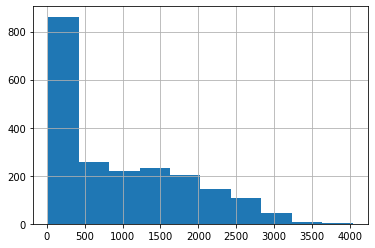

In [ ]:
def word_count(row):
    return len(row["text_modified_2"].split(" "))
data_not_na_2["wc"] = data_not_na_2.apply(word_count, axis=1)
data_not_na_2["wc"].hist()

In [ ]:
# mask = data_not_na_2[data_not_na_2["text_modified_2"].str.len() <= 128]
# mask["Level_en"].value_counts()

Counter({'1': 651, 'K': 391, '3': 325, '2': 310, '5': 214, '4': 180, '5+': 15})


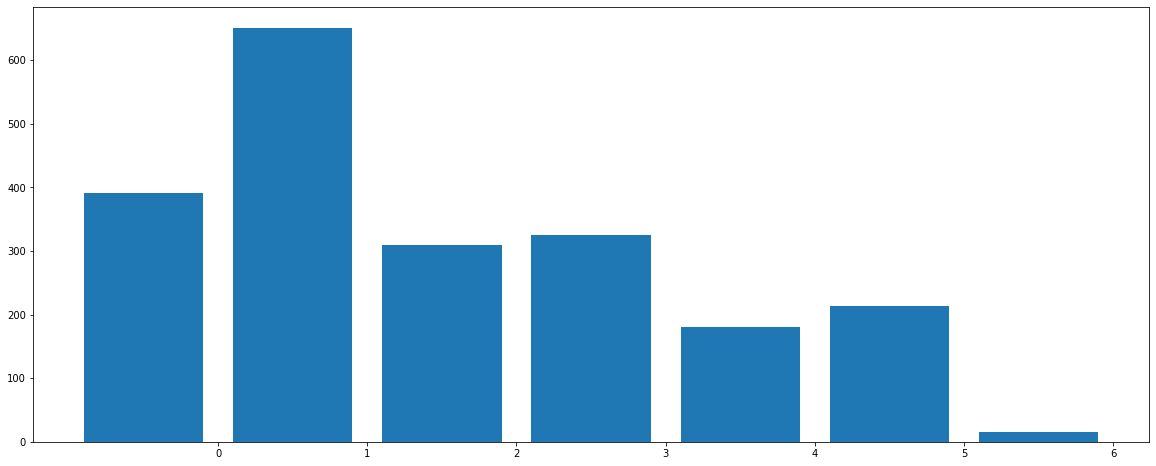

In [17]:
from collections import Counter
print(Counter(data_not_na_2['Grade']))

import matplotlib.pyplot as plt
labels, values = zip(*Counter(data_not_na_2['Grade']).items())

indexes = np.arange(len(labels))
width = 1

ind = indexes.tolist()
val = list(values)


plt.figure(figsize=(20, 8))
plt.bar(ind, val)
plt.xticks(indexes + width * 0.5, ind)
plt.show()

In [ ]:
from collections import Counter
print(Counter(data_not_na_2['Level']))

Counter({'I': 114, 'H': 111, 'aa': 99, 'C': 98, 'A': 97, 'B': 97, 'F': 93, 'J': 91, 'Q': 88, 'D': 86, 'S': 85, 'Z': 82, 'G': 80, 'T': 77, 'E': 76, 'R': 75, 'V': 70, 'X': 67, 'Y': 65, 'P': 62, 'U': 60, 'O': 58, 'L': 52, 'W': 50, 'M': 47, 'K': 46, 'N': 45, 'Z2': 12, 'Z1': 3})


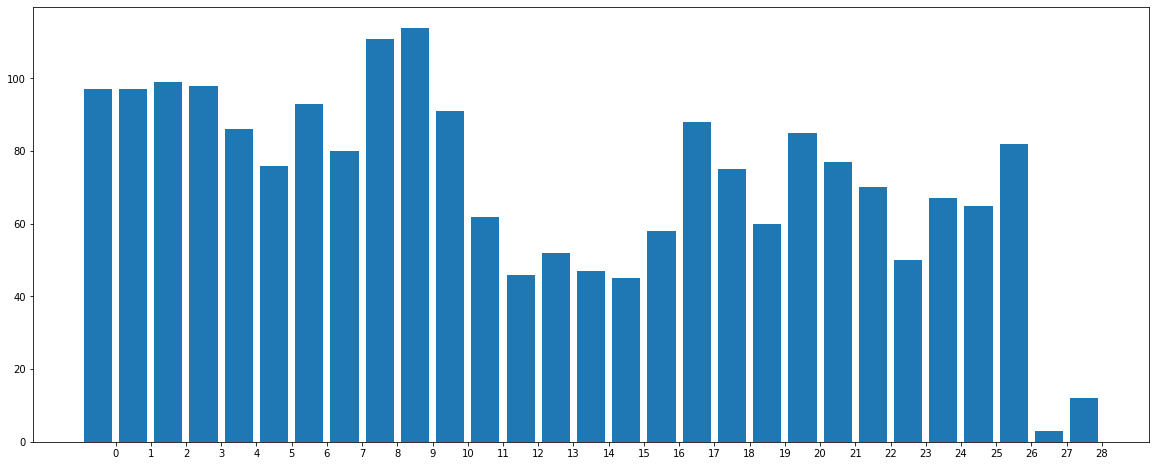

In [ ]:
import matplotlib.pyplot as plt
labels, values = zip(*Counter(data_not_na_2['Level']).items())

indexes = np.arange(len(labels))
width = 1

ind = indexes.tolist()
val = list(values)


plt.figure(figsize=(20, 8))
plt.bar(ind, val)
plt.xticks(indexes + width * 0.5, ind)
plt.show()

In [ ]:
# # data_not_na_2_fea_drop =  data_not_na_2.drop(['Level_en', 'Level'],axis=1)


# index_names = data_not_na_2[ data_not_na_2['Level'] == 'Z1' ].index   #Only 1 sample of F
# data_not_na_2.drop(index_names, inplace = True)
# data_not_na_2 = data_not_na_2.reset_index(drop=True)
# data_not_na_2.shape
# # # classification_file_3.head()

In [ ]:
# index_names = data_not_na_2[ data_not_na_2['Level'] == 'Z2' ].index   #Only 1 sample of F
# data_not_na_2.drop(index_names, inplace = True)
# data_not_na_2 = data_not_na_2.reset_index(drop=True)
# data_not_na_2.shape
# # # classification_file_3.head()

Counter({'I': 114, 'H': 111, 'aa': 99, 'C': 98, 'A': 97, 'B': 97, 'F': 93, 'J': 91, 'Q': 88, 'D': 86, 'S': 85, 'Z': 82, 'G': 80, 'T': 77, 'E': 76, 'R': 75, 'V': 70, 'X': 67, 'Y': 65, 'P': 62, 'U': 60, 'O': 58, 'L': 52, 'W': 50, 'M': 47, 'K': 46, 'N': 45, 'Z2': 12, 'Z1': 3})


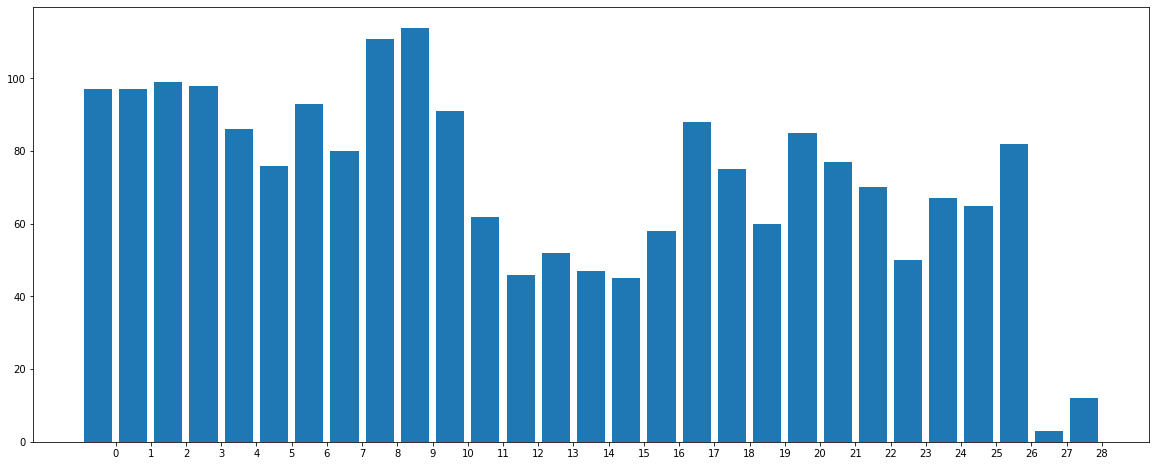

In [ ]:
print(Counter(data_not_na_2['Level']))
import matplotlib.pyplot as plt
labels, values = zip(*Counter(data_not_na_2['Level']).items())

indexes = np.arange(len(labels))
width = 1

ind = indexes.tolist()
val = list(values)


plt.figure(figsize=(20, 8))
plt.bar(ind, val)
plt.xticks(indexes + width * 0.5, ind)
plt.show()

### An easy train/test split

- Do the following for a k-fold cross validation

In [ ]:


# # train_X = data_not_na_2['text_modified_2'][:1800].tolist()
# # train_y = np.array(data_not_na_2['Level_en'][:1800])
# # test_X = data_not_na_2['text_modified_2'][1800:].tolist()
# # test_y = np.array(data_not_na_2['Level_en'][1800:])

# # len(train_X), len(train_y), len(test_X), len(test_y)
# kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=100)
# for train_index,test_index in kf.split(data_not_na_2['text_modified_2'],data_not_na_2['Level_en']):
#         #print('{} of KFold {}'.format(i,kf.n_splits))
#         # print(train_index)
#         # xtr,xvl = np.take(X, train_index), np.take(X, test_index)  #X[train_index],X[test_index]
#         # ytr,yvl = np.take(y, train_index), np.take(y, test_index)  # y[train_index],y[test_index]
#         xtr,xvl = data_not_na_2['text_modified_2'][train_index],data_not_na_2['text_modified_2'][test_index]
#         ytr,yvl = data_not_na_2['Level_en'][train_index],data_not_na_2['Level_en'][test_index]


# ## when working with k-fold startified

# train_X = xtr.tolist()
# test_X = xvl.tolist()
# train_y = ytr.to_numpy()
# test_y = yvl.to_numpy()

## Test train classification for level

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_not_na_2['text_modified_2'], data_not_na_2['Level_en'], test_size=0.20, random_state=42)    ### change to level encoding/grade encoding
train_X = X_train.tolist()
test_X = X_test.tolist()
train_y = y_train.to_numpy()
test_y = y_test.to_numpy()

## Test train classification for Grade

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_not_na_2['text_modified_2'], data_not_na_2['Grade_en'], test_size=0.20, random_state=42)    ### change to level encoding/grade encoding
train_X = X_train.tolist()
test_X = X_test.tolist()
train_y = y_train.to_numpy()
test_y = y_test.to_numpy()

In [ ]:
len(test_y)

418

Counter({7: 97, 8: 88, 28: 84, 1: 81, 9: 78, 0: 77, 2: 76, 16: 75, 5: 74, 25: 69, 3: 65, 6: 61, 19: 60, 18: 59, 17: 57, 4: 56, 24: 55, 23: 52, 15: 51, 14: 50, 21: 49, 20: 46, 11: 46, 12: 41, 22: 39, 13: 35, 10: 33, 27: 11, 26: 3})


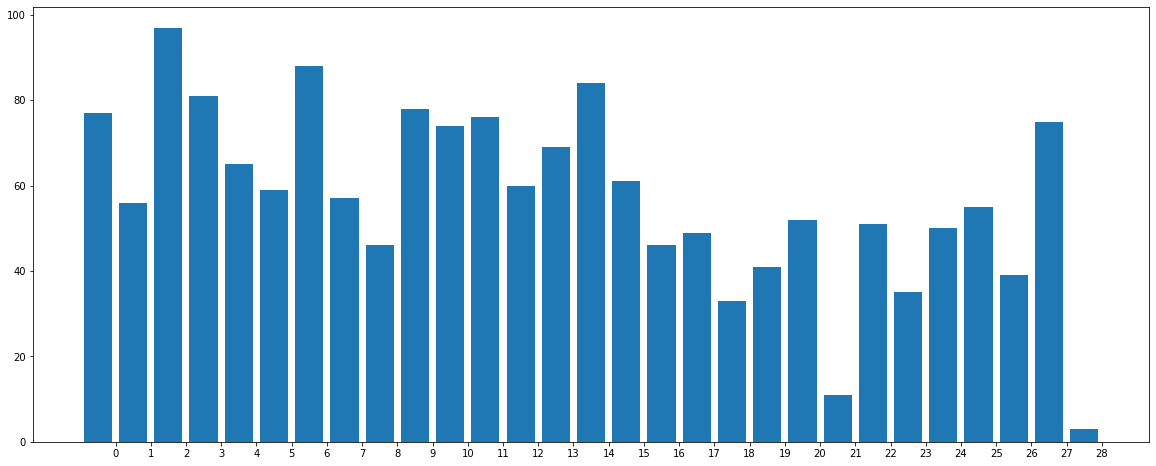

In [ ]:
type(y_train)
train_y
print(Counter(train_y))

labels, values = zip(*Counter(train_y).items())

indexes = np.arange(len(labels))
width = 1

ind = indexes.tolist()
val = list(values)


plt.figure(figsize=(20, 8))
plt.bar(ind, val)
plt.xticks(indexes + width * 0.5, ind)
plt.show()

Counter({8: 26, 18: 26, 2: 22, 21: 21, 3: 21, 4: 20, 0: 20, 6: 19, 5: 19, 17: 18, 19: 17, 1: 16, 23: 15, 28: 15, 7: 14, 20: 14, 9: 13, 10: 13, 16: 13, 25: 13, 15: 11, 22: 11, 24: 10, 13: 10, 14: 8, 11: 6, 12: 6, 27: 1})


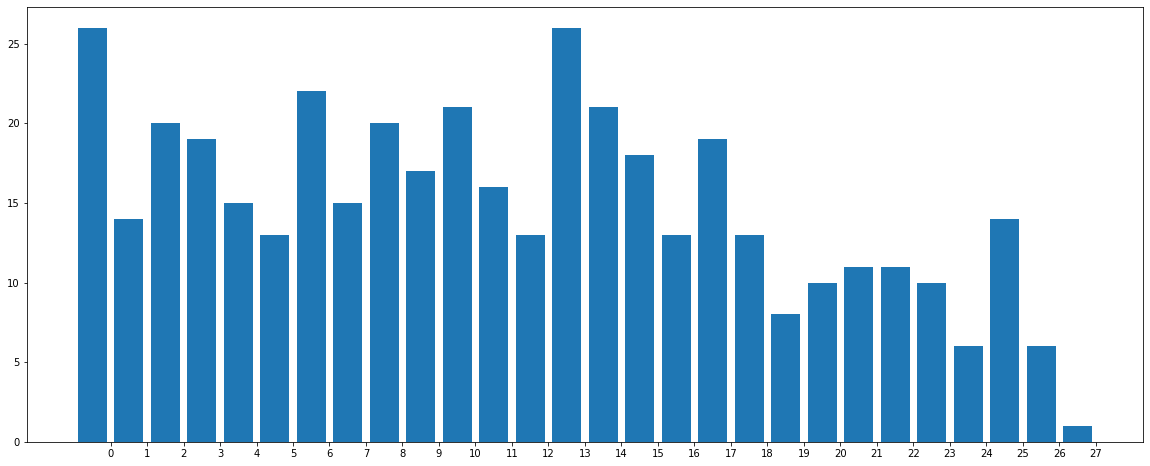

In [ ]:
type(y_train)
train_y
print(Counter(test_y))

labels, values = zip(*Counter(test_y).items())

indexes = np.arange(len(labels))
width = 1

ind = indexes.tolist()
val = list(values)


plt.figure(figsize=(20, 8))
plt.bar(ind, val)
plt.xticks(indexes + width * 0.5, ind)
plt.show()

### Fine-tune BERT on the dataset

## Torch Datasets
- takes in inputs and outputs/labels
- interfaces with tokenizer
- handles batching

In [ ]:
class MultiLabelDataset(torch.utils.data.Dataset):

    def __init__(self, text, labels, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = text
        self.targets = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

## Bert Class
- first "layer" is a pre-trained BERT model
- you can add whatever layers you want after that

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self, NUM_OUT):
        super(BERTClass, self).__init__()
                   
        self.l1 = BertModel.from_pretrained("bert-base-uncased")
#         self.pre_classifier = torch.nn.Linear(768, 256)
        self.classifier = torch.nn.Linear(768, NUM_OUT)
#         self.dropout = torch.nn.Dropout(0.5)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
#         pooler = self.pre_classifier(pooler)
#         pooler = torch.nn.Tanh()(pooler)
#         pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.softmax(output)
        return output

### Helpful Functions

Loss

- This task is binary, so it uses binary crossentropy loss
- Tasks with more labels will use categorical crossentropy
- Tasks that don't have labels, but rather have distributions should use KL divergence
- Tasks that don't have distributions should use something like RMSE loss

Train

- Steps through the data batch by batch
- grabs ids, masks, and token_type_ids which are required inputs for BERT
- inputs are passed through the model, compared to targets, computes loss function, backprops

Validation

- Takes a model, passes inputs
- Need to use the targets from here because they are potentially shuffled!

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

def train(model, training_loader, optimizer):
    model.train()
    for data in tqdm(training_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)  ### changed 

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss
    
def validation(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data in tqdm(testing_loader):
            targets = data['targets']
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            outputs = torch.sigmoid(outputs).cpu().detach()
            fin_outputs.extend(outputs)
            fin_targets.extend(targets)
    return torch.stack(fin_outputs), torch.stack(fin_targets)

### The Tokenizer

- Converts a raw string to the ids, masks, and token_type_ids

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# what does the tokenizer do?
# print(train_X)

# tokenizer.encode_plus(
#             train_X[5],
#             None,
#             add_special_tokens=True,
#             max_length=128,
#             pad_to_max_length=True,
#             truncation=True,
#             return_token_type_ids=True
#         )

### Training setup

- hyperparameters
- setup dataset
- setup parameters
- setup dataloader

## Classification for Level

In [ ]:
MAX_LEN = 128
BATCH_SIZE = 64
EPOCHS = 3
NUM_OUT = len(pd.unique(data_not_na_2['Level_en'])) # Change to levele encoding/grade encoding
LEARNING_RATE = 2e-05

training_data = MultiLabelDataset(train_X, torch.from_numpy(train_y), tokenizer, MAX_LEN)
test_data = MultiLabelDataset(test_X, torch.from_numpy(test_y), tokenizer, MAX_LEN)

train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }    

training_loader = torch.utils.data.DataLoader(training_data, **train_params)
testing_loader = torch.utils.data.DataLoader(test_data, **test_params)

### Train,  Evaluate

- model.to -> send to GPU, if available (anything computed should be put onto the GPU)
- setup optimizer - could use Stochastic Gradient Descent, but ADAM tends to work better
- for each epoch, train, show the loss, evaluate on the test data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch: 0, Loss:  3.371445417404175


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



accurracy on test set 0.14354066985645933



Epoch: 1, Loss:  3.1783647537231445



accurracy on test set 0.17942583732057416



Epoch: 2, Loss:  3.3896307945251465



accurracy on test set 0.20813397129186603


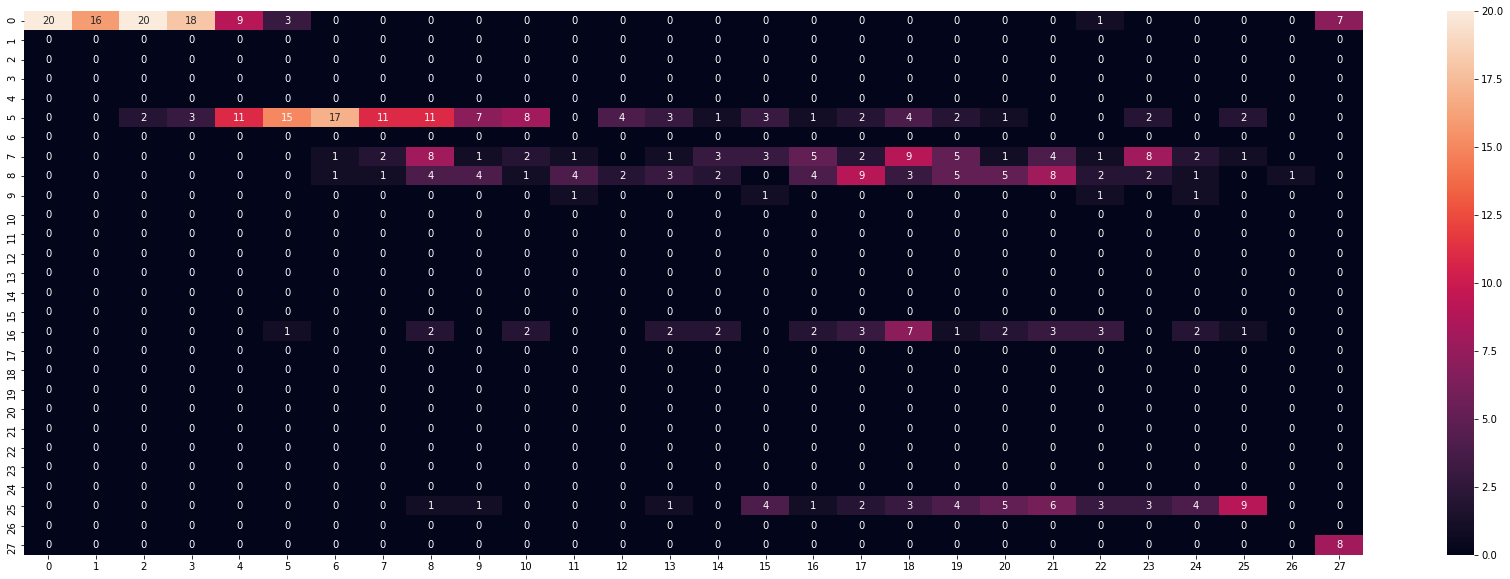

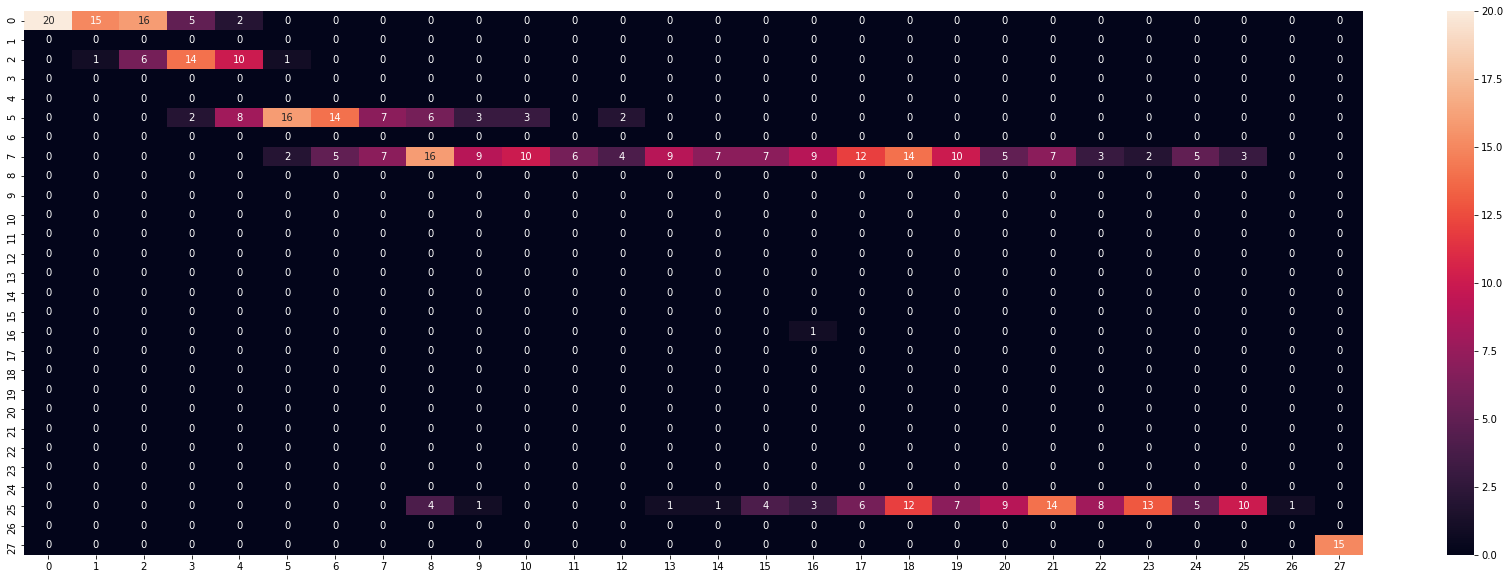

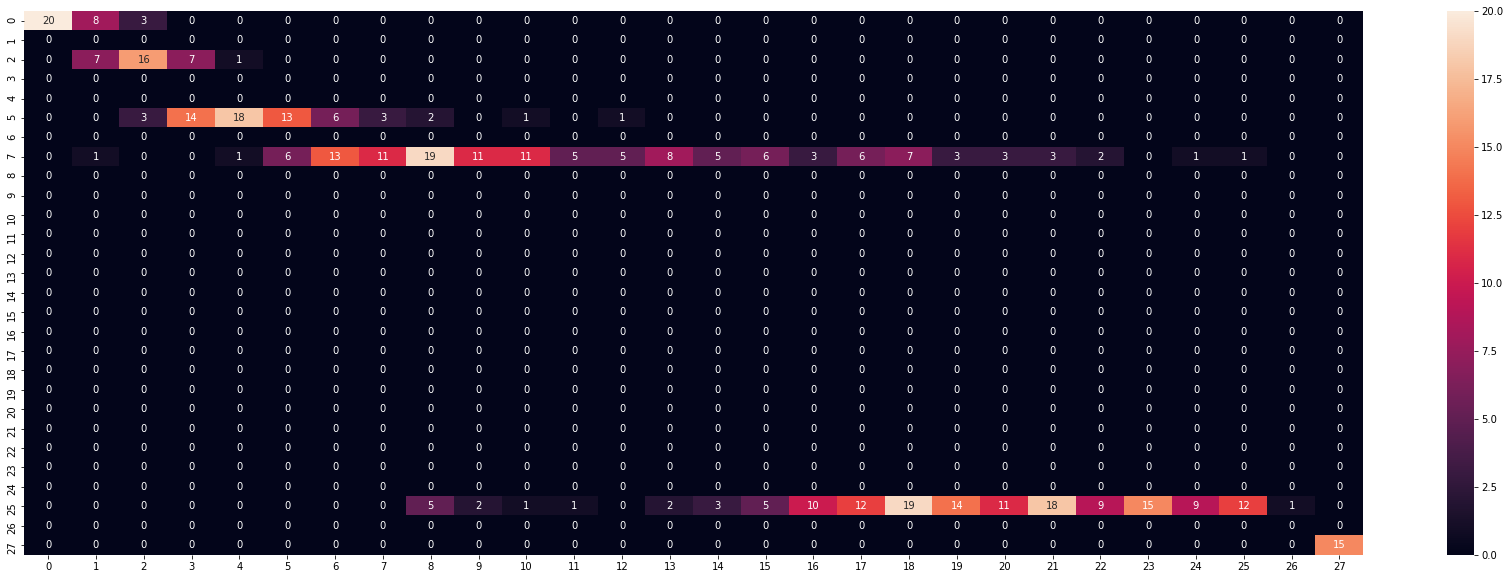

In [ ]:
model = BERTClass(NUM_OUT)
model.to(device)    

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    loss = train(model, training_loader, optimizer)
    print(f'Epoch: {epoch}, Loss:  {loss.item()}')  
    guess, targs = validation(model, testing_loader)
    guess_list = guess.tolist()
    targs_list = targs.tolist()

    final_guess = []

    for a_list in guess_list:
      maxpos = a_list.index(max(a_list))
      final_guess.append(maxpos)
    print('accurracy on test set {}'.format(accuracy_score(final_guess, targs_list)))
    # print(metrics.confusion_matrix(final_guess,targs_list))
    conf_matrix = confusion_matrix(final_guess,targs_list)
    df_cm = pd.DataFrame(conf_matrix)
    df_cm
    # DF_list.append(df_cm)

    plt.figure(figsize = (30,10))
    sn.heatmap(df_cm, annot=True)

## Classification for Grade

In [ ]:
MAX_LEN = 128
BATCH_SIZE = 64
EPOCHS = 3
NUM_OUT = len(pd.unique(data_not_na_2['Grade_en'])) # Change to level encoding/grade encoding
LEARNING_RATE = 2e-05

training_data = MultiLabelDataset(train_X, torch.from_numpy(train_y), tokenizer, MAX_LEN)
test_data = MultiLabelDataset(test_X, torch.from_numpy(test_y), tokenizer, MAX_LEN)

train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }    

training_loader = torch.utils.data.DataLoader(training_data, **train_params)
testing_loader = torch.utils.data.DataLoader(test_data, **test_params)

### Train,  Evaluate

- model.to -> send to GPU, if available (anything computed should be put onto the GPU)
- setup optimizer - could use Stochastic Gradient Descent, but ADAM tends to work better
- for each epoch, train, show the loss, evaluate on the test data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch: 0, Loss:  1.6229891777038574


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



accurracy on test set 0.49760765550239233



Epoch: 1, Loss:  1.7224042415618896



accurracy on test set 0.6124401913875598



Epoch: 2, Loss:  1.628011703491211



accurracy on test set 0.631578947368421


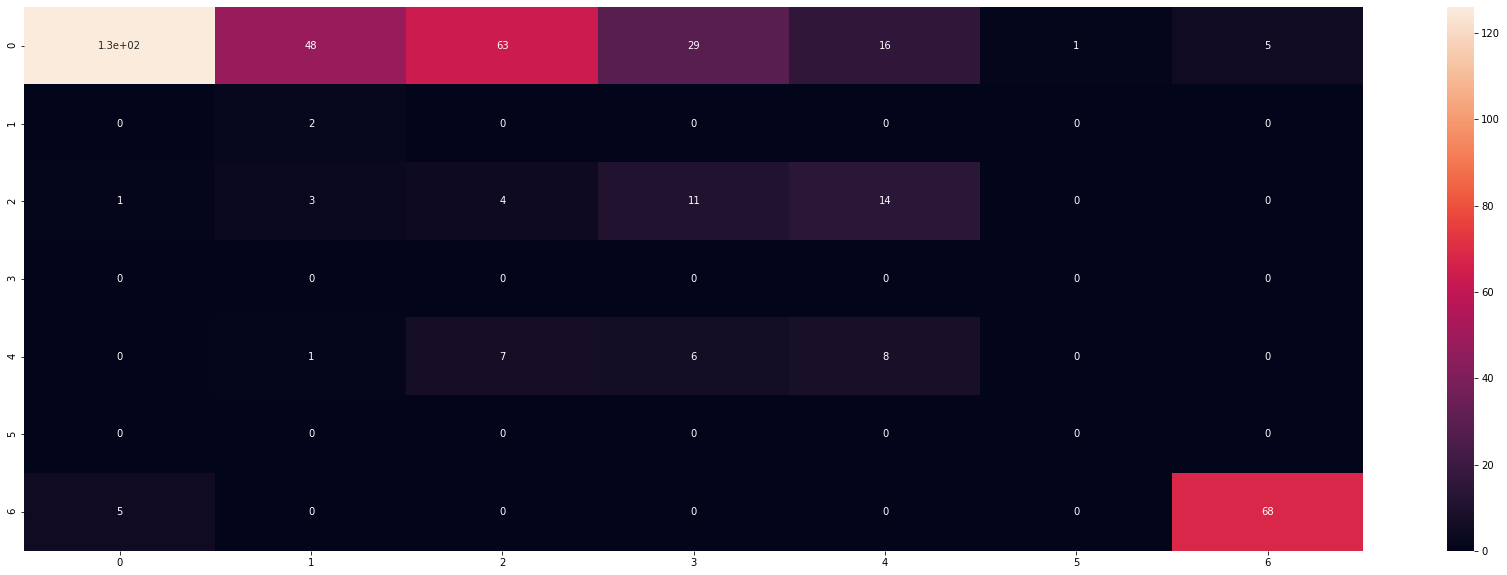

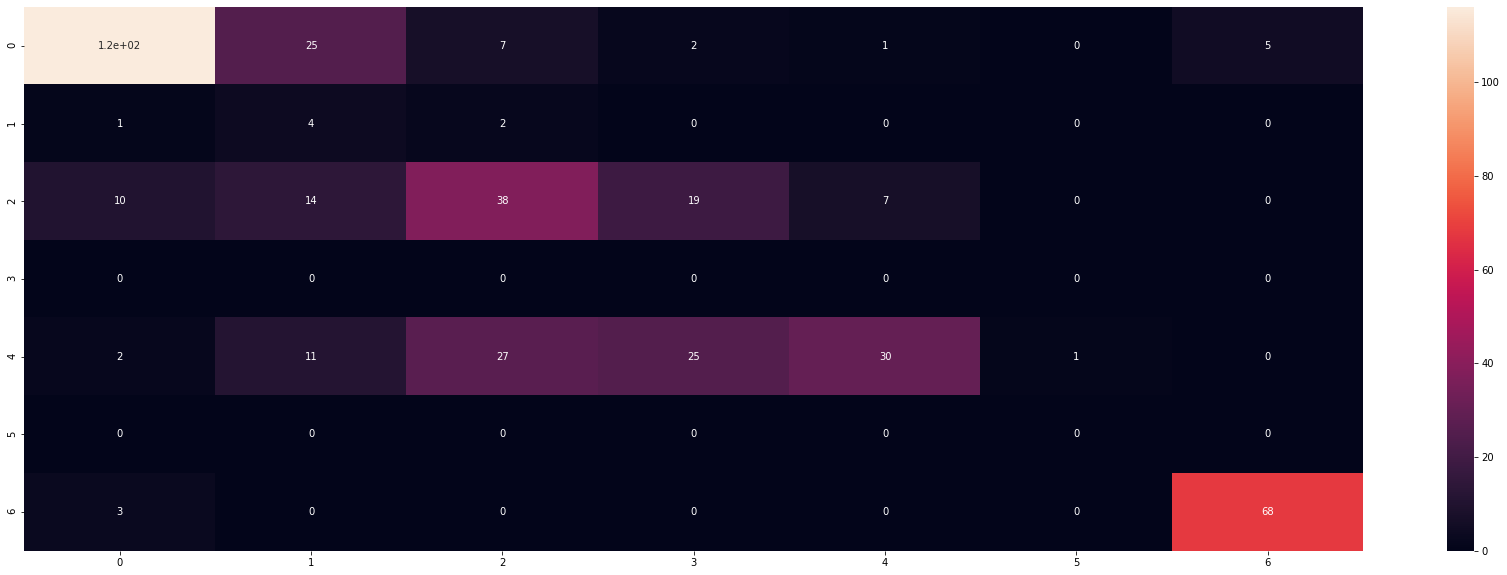

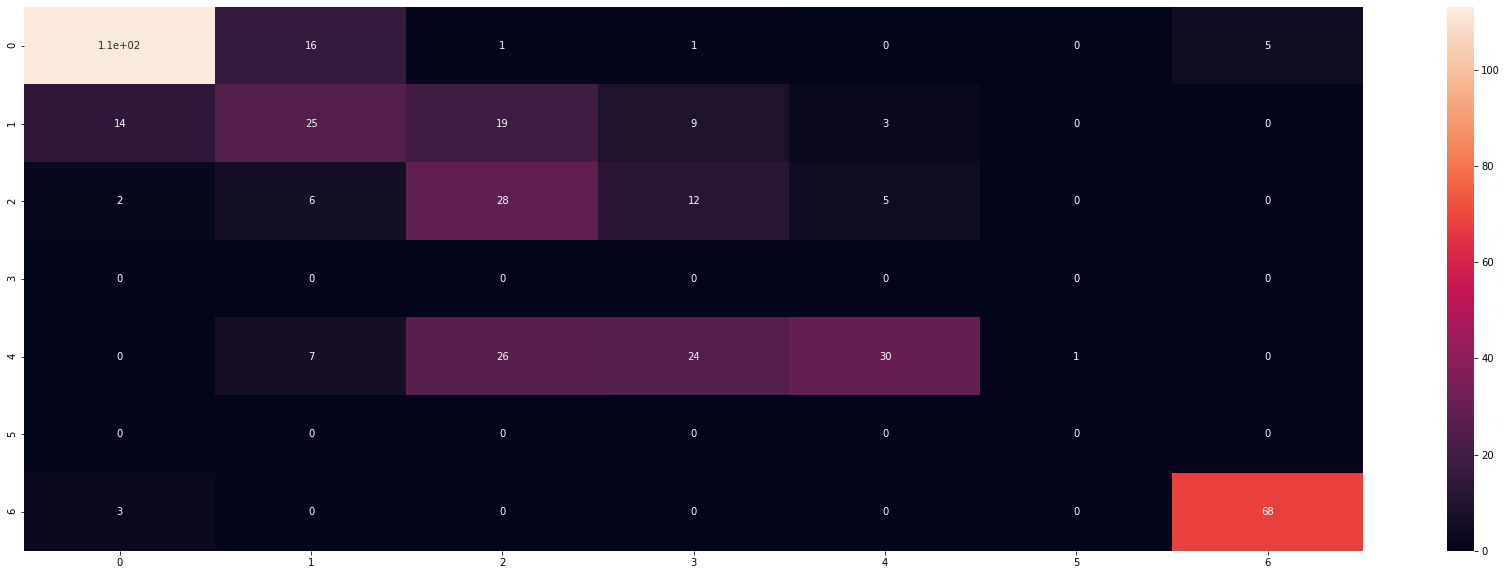

In [ ]:
model = BERTClass(NUM_OUT)
model.to(device)    

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    loss = train(model, training_loader, optimizer)
    print(f'Epoch: {epoch}, Loss:  {loss.item()}')  
    guess, targs = validation(model, testing_loader)
    guess_list = guess.tolist()
    targs_list = targs.tolist()

    final_guess = []

    for a_list in guess_list:
      maxpos = a_list.index(max(a_list))
      final_guess.append(maxpos)
    print('accurracy on test set {}'.format(accuracy_score(final_guess, targs_list)))
    # print(metrics.confusion_matrix(final_guess,targs_list))
    conf_matrix = confusion_matrix(final_guess,targs_list)
    df_cm = pd.DataFrame(conf_matrix)
    df_cm
    # DF_list.append(df_cm)

    plt.figure(figsize = (30,10))
    sn.heatmap(df_cm, annot=True)


In [ ]:
len(targs_list)

In [ ]:
len(guess_list)
# len(targs_list)

209